In [21]:
%load_ext autoreload
%autoreload 2
import os

import tensorflow as tf

import config
from MNIST_model import _input_fn, streaming_parser, model_fn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Creating a petastorm parquet file with MNIST data

Code from https://github.com/uber/petastorm/blob/master/examples/mnist/generate_petastorm_mnist.py

In [7]:
import argparse
import numpy as np
import os
import shutil
import tempfile

from pyspark.sql import SparkSession

from examples.mnist import DEFAULT_MNIST_DATA_PATH
from examples.mnist.schema import MnistSchema
from petastorm.etl.dataset_metadata import materialize_dataset
from petastorm.unischema import dict_to_spark_row


def download_mnist_data(download_dir, train=True):
    """
    Downloads the dataset files and returns the torch Dataset object, which
    represents the data as an array of (img, label) pairs.
    Each image is a PIL.Image of black-and-white 28x28 pixels.
    Each label is a long integer representing the digit 0..9.
    """
    # This is the only function requiring torch in this module.

    # Must import pyarrow before torch. See: https://github.com/uber/petastorm/blob/master/docs/troubleshoot.rst
    import pyarrow  # noqa: F401 pylint: disable=W0611,W0612
    from torchvision import datasets
    print("In download_mnist_data...")
    return datasets.MNIST('{}/{}'.format(download_dir, 'data'), train=train, download=True)


def mnist_data_to_petastorm_dataset(download_dir, output_url, spark_master=None, parquet_files_count=1,
                                    mnist_data=None):
    """Converts a directory with MNIST data into a petastorm dataset.
    Data files are as specified in http://yann.lecun.com/exdb/mnist/:
        * train-images-idx3-ubyte.gz:  training set images (9912422 bytes)
        * train-labels-idx1-ubyte.gz:  training set labels (28881 bytes)
        * t10k-images-idx3-ubyte.gz:   test set images (1648877 bytes)
        * t10k-labels-idx1-ubyte.gz:   test set labels (4542 bytes)
    The images and labels and stored in the IDX file format for vectors and multidimensional matrices of
    various numerical types, as defined in the same URL.
    :param download_dir: the path to where the MNIST data will be downloaded.
    :param output_url: the location where your dataset will be written to. Should be a url: either
      file://... or hdfs://...
    :param spark_master: A master parameter used by spark session builder. Use default value (None) to use system
      environment configured spark cluster. Use 'local[*]' to run on a local box.
    :param mnist_data: A dictionary of MNIST data, with name of dataset as key, and the dataset object as value;
      if None is suplied, download it.
    :return: None
    """
    print(f"Local download dir is {download_dir}")
    session_builder = SparkSession \
        .builder \
        .appName('MNIST Dataset Creation')
    if spark_master:
        session_builder.master(spark_master)

    spark = session_builder.getOrCreate()

    # Get training and test data
    if mnist_data is None:
        mnist_data = {
            'train': download_mnist_data(download_dir, train=True),
            'test': download_mnist_data(download_dir, train=False)
        }

    print(f"Done with local download. Starting parquet generation.")
    # The MNIST data is small enough to do everything here in Python
    for dset, data in mnist_data.items():
        dset_output_url = '{}/{}'.format(output_url, dset)
        # Using row_group_size_mb=1 to avoid having just a single rowgroup in this example. In a real store, the value
        # should be similar to an HDFS block size.
        with materialize_dataset(spark, dset_output_url, MnistSchema, row_group_size_mb=1):
            # List of [(idx, image, digit), ...]
            # where image is shaped as a 28x28 numpy matrix
            idx_image_digit_list = map(lambda idx_image_digit: {
                MnistSchema.idx.name: idx_image_digit[0],
                MnistSchema.digit.name: idx_image_digit[1][1],
                MnistSchema.image.name: np.array(list(idx_image_digit[1][0].getdata()), dtype=np.uint8).reshape(28, 28)
            }, enumerate(data))

            # Convert to pyspark.sql.Row
            sql_rows = map(lambda r: dict_to_spark_row(MnistSchema, r), idx_image_digit_list)

            # Write out the result
            spark.createDataFrame(sql_rows, MnistSchema.as_spark_schema()) \
                .coalesce(parquet_files_count) \
                .write \
                .option('compression', 'none') \
                .parquet(dset_output_url)

In [9]:
download_dir = DEFAULT_MNIST_DATA_PATH
mnist_data_to_petastorm_dataset(download_dir, config.DATASET_URL)
if os.path.exists(download_dir):
    shutil.rmtree(download_dir)

Local download dir is /tmp/mnist
In download_mnist_data...
In download_mnist_data...
Done with local download. Starting parquet generation.


# Verify input by showing an MNIST example

In [16]:
# Create a dummy args object so code can be directly copied from MNIST_model.py and checked here

class Object(object):
    pass

args = Object()
args.dataset_url = config.DATASET_URL
args.prefetch_size = 2
args.batch_size = 10
args.num_parallel_batches = 2
worker_index=0
nr_workers=1

In [19]:
with make_reader(os.path.join(args.dataset_url, 'train'),
                 num_epochs=None,
                 workers_count=nr_workers,
                 shard_count=nr_workers,
                 cur_shard=worker_index,) as reader:
    exp_dataset = _input_fn(reader = reader,
                            batch_size=args.batch_size,
                            num_parallel_batches=args.num_parallel_batches)

W0626 21:37:44.089046 139620851508992 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0626 21:37:44.089930 139620851508992 deprecation.py:323] From /mnt/tf_example.py:95: map_and_batch (from tensorflow.contrib.data.python.ops.batching) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.experimental.map_and_batch(...)`.
W0626 21:37:44.090412 139620851508992 deprecation.py:323] From /opt/miniconda/envs/py3/lib/python3.6/site-packages/tensorflow/contrib/data/python/ops/batching.py:273: map_and_batch (from tensorflow.python.data.experimental.ops.batching) is deprecated and will be removed in a future version.
Instru

In [22]:
features, labels = exp_dataset.make_one_shot_iterator().get_next()
with tf.Session() as sess:
    features_manifested, labels_manifested = sess.run([features, labels])

Shape of features should be (10, 784) with 784 = 28 x 28 unrolled

In [24]:
features_manifested['image'].shape

(10, 784)

In [28]:
labels_manifested.shape

(10,)

0


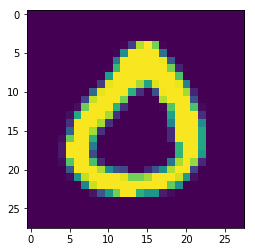

In [35]:
import matplotlib.pyplot as plt
import random
index = random.randint(0, 9)

print(labels_manifested[index])
plt.imshow(features_manifested['image'][index,:].reshape((28,28)))

# Experimenting with batches and shards

In [41]:
import tensorflow as tf
from petastorm import make_reader
from petastorm.tf_utils import make_petastorm_dataset


def streaming_parser(serialized_example):   
    image_data = tf.cast(tf.reshape(serialized_example.image, [784]), tf.float32)
    label = serialized_example.digit
    return {"image_data": image_data}, label


# Watch out, cur_shard is 0-based, so a value of 2 (shard_count) will raise OutOfRangeError
# This error will be silenced in Tensorflow Estimator 😱
with make_reader(os.path.join(args.dataset_url, 'train'),
                 num_epochs=None,
                 workers_count=2,
                 shard_count=2,
                 cur_shard=1,) as reader:
    exp_dataset = _input_fn(reader = reader,
                            batch_size=1000,
                            num_parallel_batches=2)

    features, labels = exp_dataset.make_one_shot_iterator().get_next()

    with tf.Session() as sess:
        sess.run(tf.local_variables_initializer())
        sess.run(tf.global_variables_initializer())
        cum_count = 0
        for idx in range(61):  # see what happens if we reach the end of the data
            labels_manifested = sess.run([labels])
            count = labels_manifested[0].shape[0]
            cum_count += count
            print(f"Batch {idx}, contains {count} records, total records read is {cum_count}")

Batch 0, contains 1000 records, total records read is 1000
Batch 1, contains 1000 records, total records read is 2000
Batch 2, contains 1000 records, total records read is 3000
Batch 3, contains 1000 records, total records read is 4000
Batch 4, contains 1000 records, total records read is 5000
Batch 5, contains 1000 records, total records read is 6000
Batch 6, contains 1000 records, total records read is 7000
Batch 7, contains 1000 records, total records read is 8000
Batch 8, contains 1000 records, total records read is 9000
Batch 9, contains 1000 records, total records read is 10000
Batch 10, contains 1000 records, total records read is 11000
Batch 11, contains 1000 records, total records read is 12000
Batch 12, contains 1000 records, total records read is 13000
Batch 13, contains 1000 records, total records read is 14000
Batch 14, contains 1000 records, total records read is 15000
Batch 15, contains 1000 records, total records read is 16000
Batch 16, contains 1000 records, total reco